# Implementing Google’s Deep Dream

Firstly I'm loading the InceptionV3 model which tends to produce some of the best visuals.

In [1]:
# Import the libraries we need to start putting Google's Deep Dream together
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
import tensorflow as tf
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

### Image Loader Function
Loading the image, resize it to a width of 350. Then I'm swapping the color channels from BGR to RGB, and returning the image as a NumPy array.

In [2]:
def loadImage(imagePath):
    '''returns the image pixel array resiezd to a width of 350'''
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=350)
    # convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)
    return image

### Deprocess Function 
Utility function to convert a tensor into a valid image. It "undoes" the preprocessing done for Inception and then casts the pixel values to integers

In [3]:
def deprocess(image):
    '''returns the deprocessed image'''
    image = 255 * (image + 1.0) 
    image /= 2.0
    image = tf.cast(image, tf.uint8)
    return image

### Calculate the loss after a single iteration of the DeepDream algorithm

Firstly I'm adding a batch dimension to the image and then grab the activations, from specified layers of the Inception network after performing a forward pass.

In [4]:
def calculateLoss(image, model):
    '''returns the sum of losses'''
    image = tf.expand_dims(image, axis=0)
    layerActivations = model(image)

    # Create a list to store the intermediate losses
    losses = []

    # iterate over the layer activations
    for act in layerActivations:
        # compute the mean of each activation
        loss = tf.reduce_mean(act)
        # append these losses to the losses list
        losses.append(loss)

    # return the sum of the losses
    return tf.reduce_sum(losses)

## The Deep Dream function

This function performs a forward-pass and then taking the
gradients and using them to update the input image to generate the deep dream effects.

I'm inputting our model (inception network preferablly), the input image, the step size we use for our gradient updates and EPS, a tiny value used to prevent divide by zero errors.

In [5]:
# This is new addition to TF2.0. When we use the **tf.function** decorator to a function.
# TensorFlow will automatically compile it into a graph which leads to faster execution.
@tf.function
def deepDreamSinglePass(model, image, stepSize, eps=1e-8):
    ''' returns a tuple of the loss and the updated image'''

    # Tells TenorFlow to record gradients
    with tf.GradientTape() as tape:
        # keep track of the image to calculate gradients and loss 
        tape.watch(image)
        loss = calculateLoss(image, model)

    # calculates the gradients of the loss with respect to the image
    gradients = tape.gradient(loss, image)
    # normalize the gradients 
    gradients /= tf.math.reduce_std(gradients) + eps 
    # K.maximum(K.mean(K.abs(grads)), K.epsilon())

    # adjusts the image with the normalized gradients 
    image = image + (gradients * stepSize)
    # clip its pixel values to the range [-1, 1]
    image = tf.clip_by_value(image, -1, 1)

    return (loss, image)

### Function that runs our Deep Dream Model

Up to this point I can perform a single forward-pass of the DeepDream algorithm. Now I need to design our training loop that enables us to do this for multiple iterations.

The `fullDeepDreamModel` will be making below will allow to pass the model (inception) and input image for a specified number of iterations.

In [6]:
def fullDeepDreamModel(model, image, iterations=50, stepSize=0.01):
    '''runs the deep dream algorithm for a specified number of iterations 
    and returns the depresocessed image'''

    # preprocess the image for the Inception network
    image = preprocess_input(image)

    # We iterate for the specified number of iterations
    for iteration in range(iterations):
        # use  our deepDreamSinglePass function to get the loss and the updated image
        (loss, image) = deepDreamSinglePass(model, image, stepSize)

        # print updates on the iteration progress
        if iteration % 50 == 0:
            print ("Iteration {} with loss {}".format(iteration, loss))

    return deprocess(image)

#### Defining the layers we are going to use for the dream


In [7]:
# Chose the layers you'll be using 
names = ["mixed3", "mixed5", "mixed7"]

# define the octave scale and number of octaves (tweaking these values
# will produce different output dreams)
OCTAVE_SCALE = 1.3
NUM_OCTAVES = 2

### Execute Deep Dream

Loaded Image
Loading Inception Model...
Loaded Inception Model


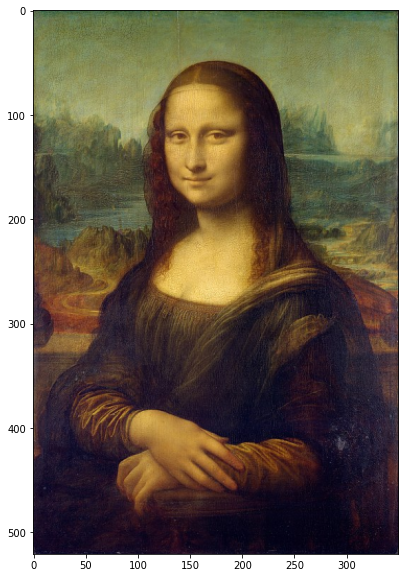

In [8]:
# get our input image
sampleImage = loadImage('515px-Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
print("Loaded Image")

# load the pre-trained Inception model from disk
print("Loading Inception Model...")
baseModel = InceptionV3(include_top=False, weights="imagenet")
print("Loaded Inception Model")

# shows the original image
plt.figure(figsize=(20,10)) 
plt.imshow(sampleImage);

In [12]:
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
# build the dreaming model
layers = [baseModel.get_layer(name).output for name in names]
deepDreamModel = tf.keras.Model(inputs=baseModel.input, outputs=layers)

# Convert the image to a TensorFlow constant for better performance,
image = tf.constant(sampleImage)

# Take the first two dimensions of the image and cast then them to float
baseShape = tf.cast(tf.shape(image)[:-1], tf.float32)

# Run our Deep Dream Generator!



Working on octave 0
Iteration 0 with loss 0.6320562958717346
Iteration 50 with loss 1.2171564102172852
Working on octave 1
Iteration 0 with loss 0.7600582242012024
Iteration 50 with loss 1.3377615213394165


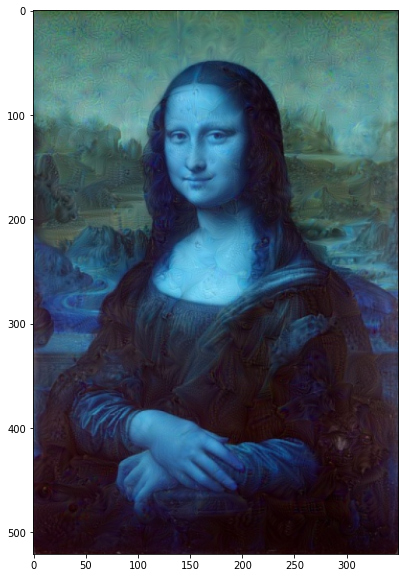

In [11]:
import matplotlib.pyplot as plt

# Iterate over the number of Octaves (sizes) we are going to create using Deep Dream
for n in range(NUM_OCTAVES):

    # get the width and height for the current octave and cast them to integers
    print("Working on octave {}".format(n))
    newShape = tf.cast(baseShape * (OCTAVE_SCALE ** n), tf.int32)

    # Resize the image with new shape and convert it to numpy before running 
    # through our DeepDream Model
    image = tf.image.resize(image, newShape).numpy()
    image = fullDeepDreamModel(model=deepDreamModel, image=image, iterations=100, stepSize=0.001)

# convert the final image to a numpy array and then save it to disk
finalImage = np.array(image)
cv2.imwrite('output.jpg', finalImage)

plt.figure(figsize=(20,10)) 
plt.imshow(loadImage("output.jpg"));